In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression as LR
import numpy as np
import os
from sklearn.metrics import r2_score
import xgboost as xgb
from scipy.stats import gaussian_kde
import matplotlib as mpl

In [2]:
def get_lim(x,y):
    L_lim = np.min([np.min(x),np.min(y)])
    H_lim = np.max([np.max(x),np.max(y)])
    
    rg = H_lim-L_lim
    return [L_lim-rg*0.05,H_lim+rg*0.05]

In [3]:
def dense_plot(x,y):
    # x experimental
    mpl.rcParams['image.cmap'] = 'jet'
    mpl.rcParams["font.size"] = 10
    lr = LR()
    x = x.ravel()
    y = y.ravel()
    n = x.shape[0]
    print(x.shape,y.shape)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x, y, c=z, s=10, edgecolor='')
    #plt.xlabel('Predicted ($^\circ$C)')
    plt.xlabel('Experimental ($^\circ$C)')


In [4]:
def plot_errors(infile,weighted_r2=False,lim=None):
    df = pd.read_csv(infile,index_col=0)
    
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    dense_plot(df['true'].values,df['pred'].values-df['true'].values)
    plt.xlabel('Experimental OGT ($^\circ$C)')
    plt.ylabel('Residual ($^\circ$C)')
    plt.ylim([-40,40])
    
    #lim = get_lim(df['true'],df['pred'])
    if lim is None:lim = [0,120]
    plt.plot(lim,[0,0],'k--')
    
    plt.xlim(lim)
    intv = (lim[1]-lim[0])//5
    plt.xticks(np.arange(lim[0],lim[1]+intv,intv))
    
    plt.subplot(1,3,2)
    dense_plot(df['pred'].values,df['pred'].values-df['true'].values)
    plt.xlabel('Predicted OGT ($^\circ$C)')
    plt.ylabel('Residual ($^\circ$C)')
    
    plt.ylim([-40,40])
    plt.plot(lim,[0,0],'k--')
    plt.xlim(lim)
    
    intv = (lim[1]-lim[0])//5
    plt.xticks(np.arange(lim[0],lim[1]+intv,intv))
    
    plt.subplot(1,3,3)
    if weighted_r2:
        wfile = os.path.join('../data/',infile.split('/')[-1].split('csv')[0]+'csv')
        dfdimer = pd.read_csv(wfile,index_col=0)
        dfdimer = dfdimer.loc[df.index,:]
        r2w = r2_score(df['true'],df['pred'],sample_weight=dfdimer['weight'])
    r2 = r2_score(df['true'],df['pred'])
    
    x = df['true'].values
    y = df['pred'].values
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    plt.scatter(x, y, c=z, s=10, edgecolor='')
    plt.xlabel('Experimental OGT ($^\circ$C)')
    plt.ylabel('Predicted OGT ($^\circ$C)')
    plt.plot(lim,lim,'k--')
    plt.xlim(lim)
    plt.xticks(np.arange(lim[0],lim[1]+intv,intv))
    plt.ylim(lim)
    if weighted_r2:plt.title('$R^2$={0:.2f}({1:.2f})'.format(r2w,r2))
    else: plt.title('$R^2$={0:.2f}'.format(r2))
    
    plt.tight_layout()
    plt.show()

In [33]:
def plot_residual_comparison(in1,in2):
    
    def _load_data(infile):
        df = pd.read_csv(infile,index_col=0)
        
        # group orgs based on exp ogt, bin size of 5 degress
        org_bins = {}
        for ind in df.index:
            index = int(df.loc[ind,'true']//5)
            org_bins[index] = org_bins.get(index,[]) + [ind]
        
        # calculate residual
        res_bins = {}
        for index,org_bin in org_bins.items():
            res_bins[index] = [df.loc[ind,'pred']-df.loc[ind,'true'] for ind in org_bin]
            
                
        # sorted_nbins
        lst = list(res_bins.items())
        lst.sort()
        
        sorted_bins = [item[1] for item in lst]
        temps = [item[0]*5+2.5 for item in lst]
        return sorted_bins,temps
    
    def _extract_percentiles(bins):
        ps = list()
        for mem in bins:
            ps.append(list(np.percentile(mem,[2.5,50,97.5]))) 
        return np.array(ps)
    
    def _do_fill_plot(temp,ps,label):
        plt.plot(temp,ps[:,1],label=label)
        plt.fill_between(temp,ps[:,0],ps[:,2],alpha=0.5)
        
    
    sorted_bins1,temps1 = _load_data(in1)
    sorted_bins2,temps2 = _load_data(in2)   
        
    ps1 = _extract_percentiles(sorted_bins1)
    ps2 = _extract_percentiles(sorted_bins2)
    
    plt.figure(figsize=(4,3))
    _do_fill_plot(temps1,ps1,'Original')
    _do_fill_plot(temps2,ps2,'Weighted')
    
    lim = [0,120]
    plt.plot(lim,[0,0],'k--')
    plt.xlim(lim)
    plt.ylim([-30,30])
    
    plt.xlabel('Experimental OGT ($^\circ$C)')
    plt.ylabel('Residual ($^\circ$C)')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

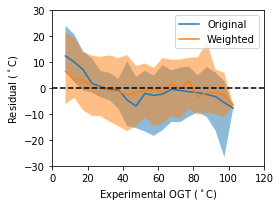

In [34]:
plot_residual_comparison('../results/ml_classical_models/dimer_updated_with_madin_bowman.csv_SVR_model.csv',
                         '../results/ml_classical_models/dimer_updated_with_madin_bowman_uniform_weights.csv_BayesRige.csv')

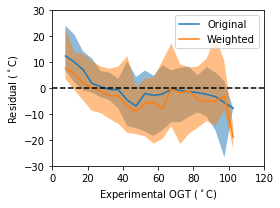

In [35]:
plot_residual_comparison('../results/ml_classical_models/dimer_updated_with_madin_bowman.csv_SVR_model.csv',
                         '../results/ml_classical_models/dimer_updated_with_madin_bowman_0.80_weights.csv_xboxFalse_yboxFalse_BayesRige.csv')

In [8]:
?np.percentile

In [7]:
np.percentile([1,2,4,5,5],[10,30])[0]

1.4

dimer_updated_with_madin_bowman.csv_Tree_model.csv
(6020,) (6020,)
(6020,) (6020,)


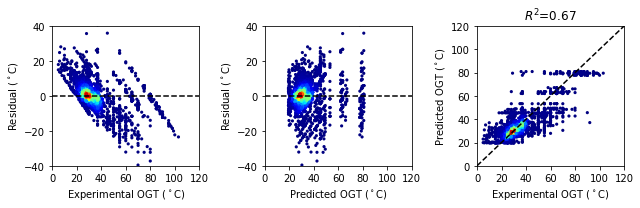

dimer_updated_with_madin_bowman.csv_SVR_model.csv
(6020,) (6020,)
(6020,) (6020,)


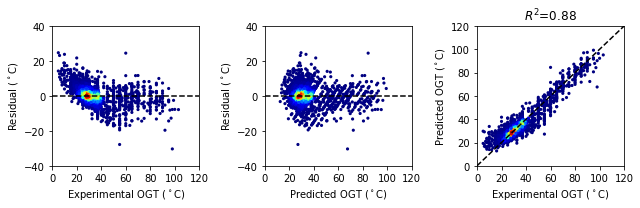

dimer_updated_with_madin_bowman.csv_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


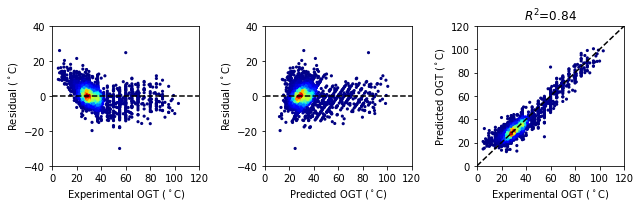

dimer_updated_with_madin_bowman.csv_Elastic_Net.csv
(6020,) (6020,)
(6020,) (6020,)


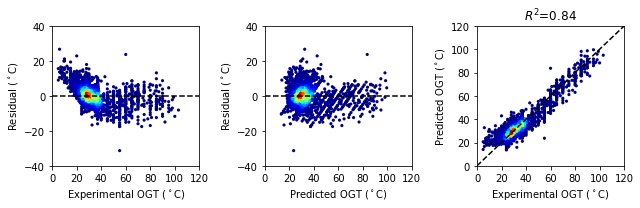

dimer_updated_with_madin_bowman.csv_XGBoost.csv
(6020,) (6020,)
(6020,) (6020,)


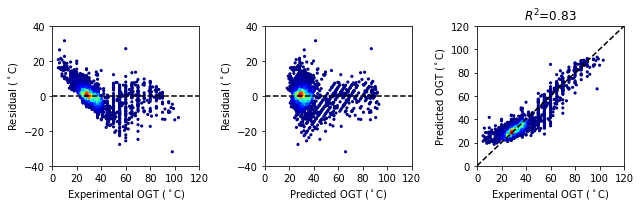

dimer_updated_with_madin_bowman.csv_Random_forest.csv
(6020,) (6020,)
(6020,) (6020,)


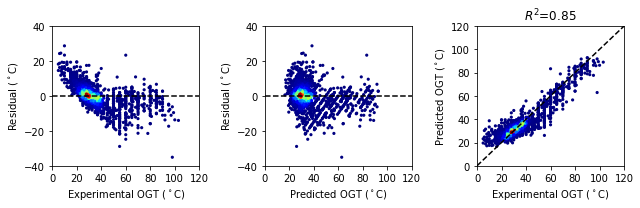

dimer_updated_with_madin_bowman.csv_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


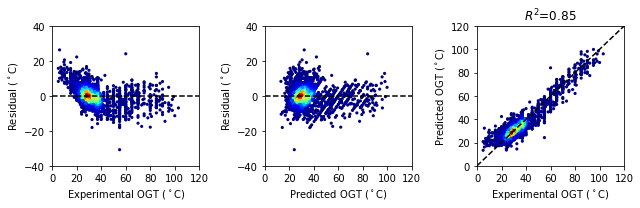

In [50]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and 'uniform' not in name and 'box' not in name and 'reduce' not in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile)

dimer_updated_with_madin_bowman_uniform_weights.csv_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


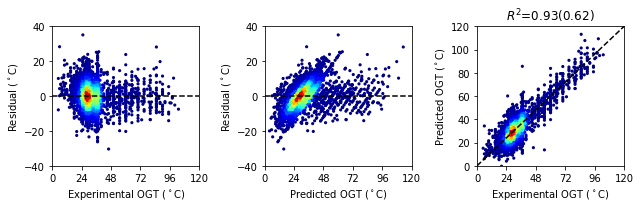

dimer_updated_with_madin_bowman_uniform_weights.csv_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


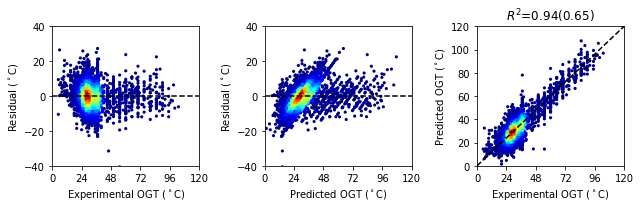

dimer_updated_with_madin_bowman_uniform_weights.csv_Random_forest.csv
(6020,) (6020,)
(6020,) (6020,)


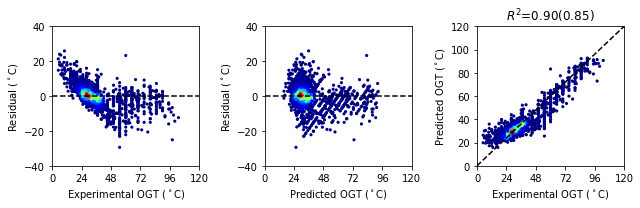

dimer_updated_with_madin_bowman_uniform_weights.csv_SVR_model.csv
(6020,) (6020,)
(6020,) (6020,)


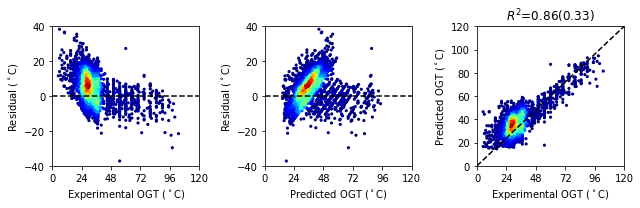

dimer_updated_with_madin_bowman_uniform_weights.csv_Tree_model.csv
(6020,) (6020,)
(6020,) (6020,)


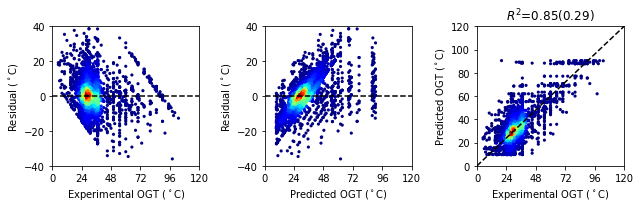

In [62]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and 'uniform' in name and 'box' not in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_reduce37.csv_Tree_model.csv
(4737,) (4737,)
(4737,) (4737,)


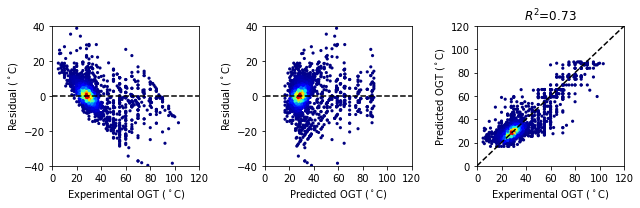

dimer_updated_with_madin_bowman_reduce37.csv_BayesRige.csv
(4737,) (4737,)
(4737,) (4737,)


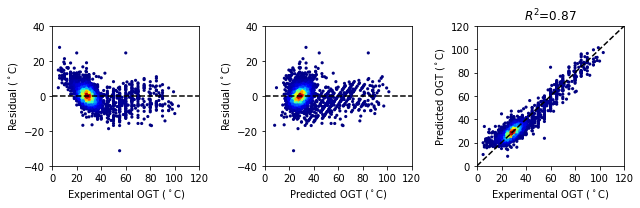

dimer_updated_with_madin_bowman_reduce37.csv_SVR_model.csv
(4737,) (4737,)
(4737,) (4737,)


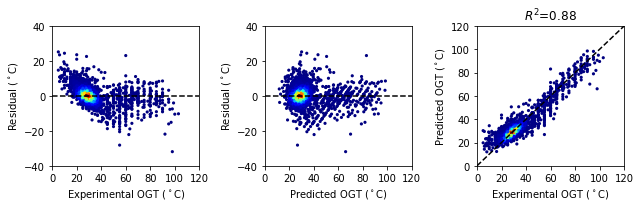

dimer_updated_with_madin_bowman_reduce37.csv_Linear.csv
(4737,) (4737,)
(4737,) (4737,)


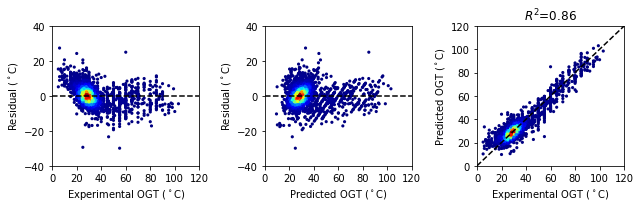

dimer_updated_with_madin_bowman_reduce37.csv_Elastic_Net.csv
(4737,) (4737,)
(4737,) (4737,)


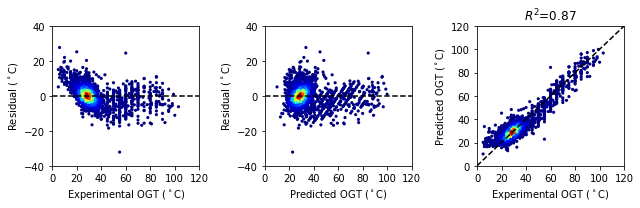

dimer_updated_with_madin_bowman_reduce37.csv_Random_forest.csv
(4737,) (4737,)
(4737,) (4737,)


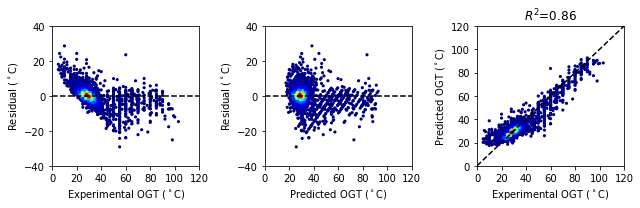

In [52]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and 'reduce' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile)

dimer_updated_with_madin_bowman.csv_xboxTrue_yboxFalse_Elastic Net.csv
(6020,) (6020,)
(6020,) (6020,)


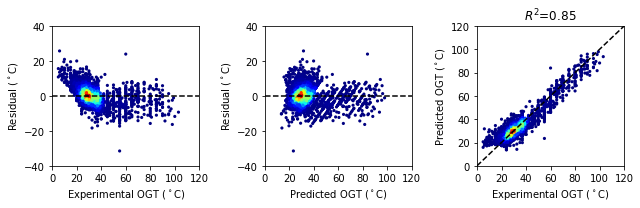

dimer_updated_with_madin_bowman.csv_xboxTrue_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


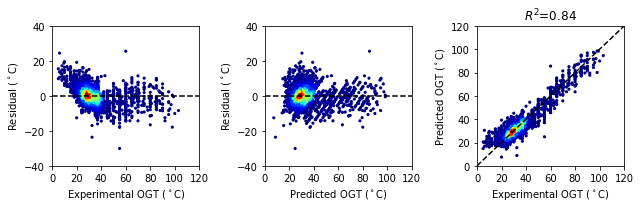

dimer_updated_with_madin_bowman_uniform_weights.csv_xboxTrue_yboxFalse_SVR model.csv
(6020,) (6020,)
(6020,) (6020,)


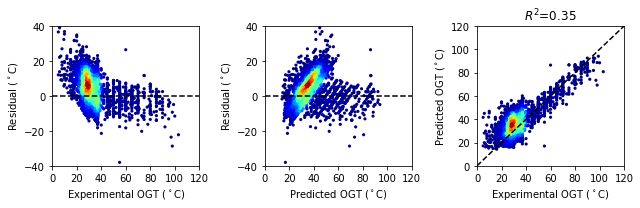

dimer_updated_with_madin_bowman_uniform_weights.csv_xboxTrue_yboxFalse_Tree model.csv
(6020,) (6020,)
(6020,) (6020,)


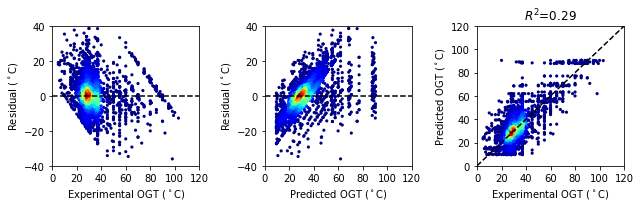

dimer_updated_with_madin_bowman.csv_xboxTrue_yboxFalse.csv
(6020,) (6020,)
(6020,) (6020,)


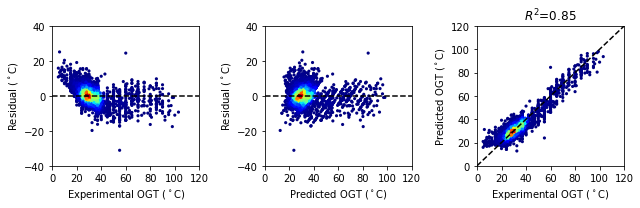

dimer_updated_with_madin_bowman.csv_xboxTrue_yboxFalse_Random forest.csv
(6020,) (6020,)
(6020,) (6020,)


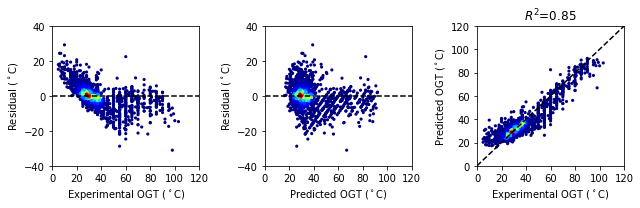

dimer_updated_with_madin_bowman_uniform_weights.csv_xboxTrue_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


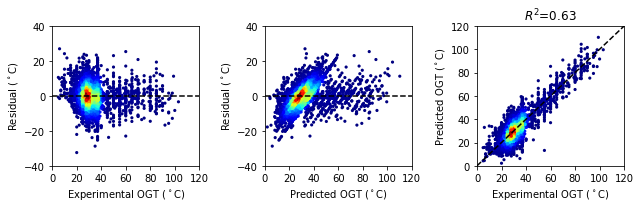

dimer_updated_with_madin_bowman_uniform_weights.csv_xboxTrue_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


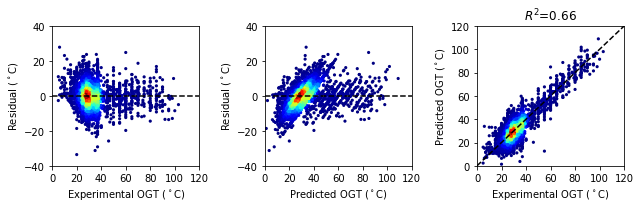

dimer_updated_with_madin_bowman.csv_xboxTrue_yboxFalse_Tree model.csv
(6020,) (6020,)
(6020,) (6020,)


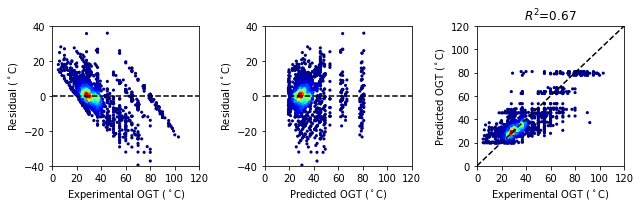

dimer_updated_with_madin_bowman.csv_xboxTrue_yboxFalse_SVR model.csv
(6020,) (6020,)
(6020,) (6020,)


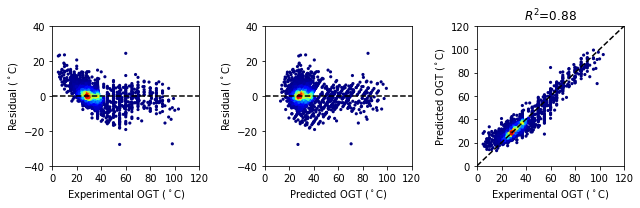

dimer_updated_with_madin_bowman.csv_xboxTrue_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


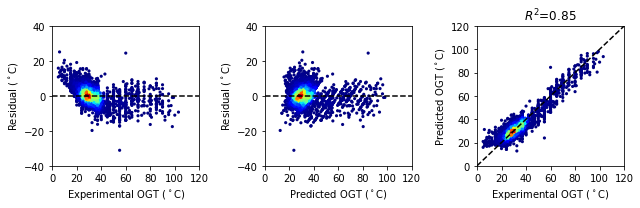

In [53]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and 'xboxTrue_yboxFalse' in name :
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile)

dimer_updated_with_madin_bowman_uniform_weights.csv_xboxTrue_yboxFalse_SVR model.csv
(6020,) (6020,)
(6020,) (6020,)


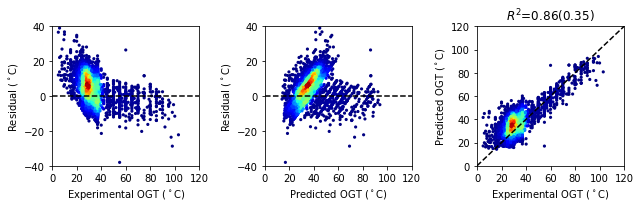

dimer_updated_with_madin_bowman_uniform_weights.csv_xboxTrue_yboxFalse_Tree model.csv
(6020,) (6020,)
(6020,) (6020,)


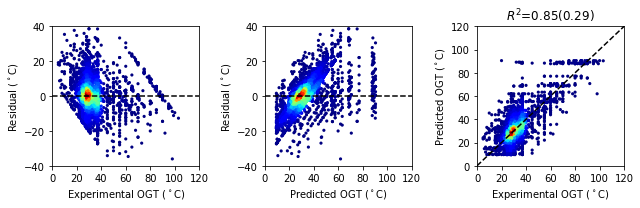

dimer_updated_with_madin_bowman_uniform_weights.csv_xboxTrue_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


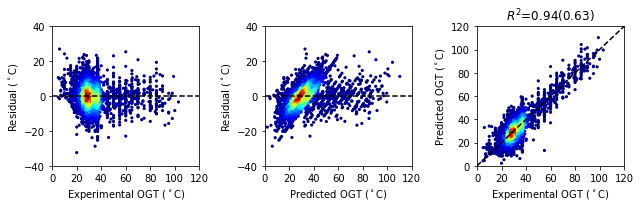

dimer_updated_with_madin_bowman_uniform_weights.csv_xboxTrue_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


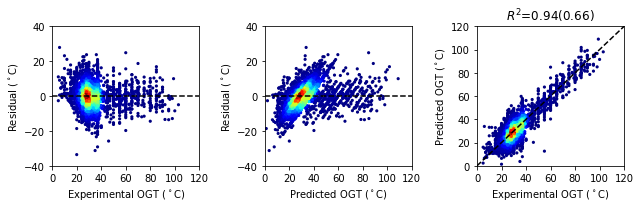

In [54]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and 'xboxTrue_yboxFalse' in name and 'weight' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_kingdom_archaea.csv_xboxFalse_yboxFalse_Random forest.csv
(235,) (235,)
(235,) (235,)


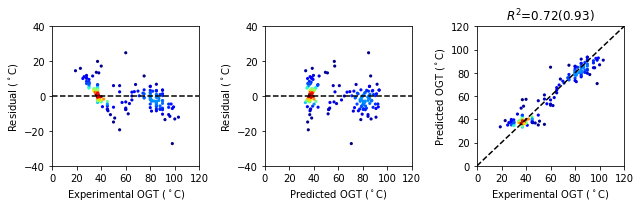

dimer_updated_with_madin_bowman_kingdom_archaea.csv_xboxFalse_yboxFalse_BayesRige.csv
(235,) (235,)
(235,) (235,)


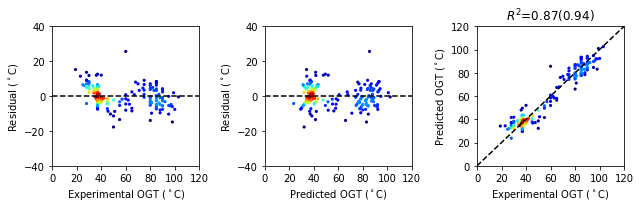

dimer_updated_with_madin_bowman_kingdom_archaea.csv_xboxFalse_yboxFalse_Linear.csv
(235,) (235,)
(235,) (235,)


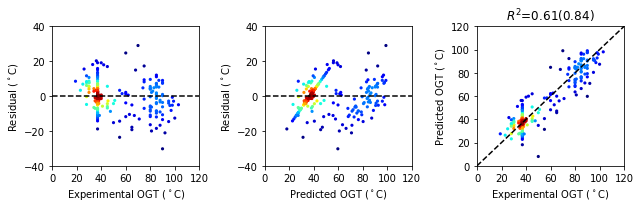

dimer_updated_with_madin_bowman_kingdom_archaea.csv_xboxFalse_yboxFalse_SVR model.csv
(235,) (235,)
(235,) (235,)


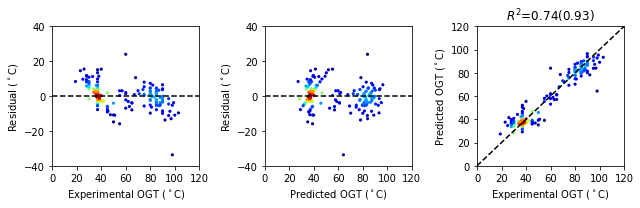

dimer_updated_with_madin_bowman_kingdom_archaea.csv_xboxFalse_yboxFalse_Tree model.csv
(235,) (235,)
(235,) (235,)


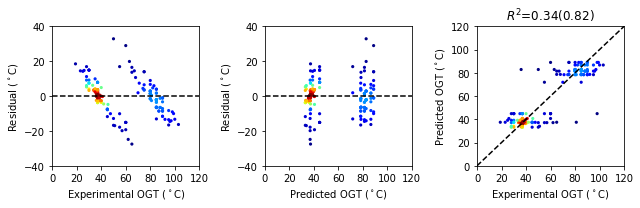

In [57]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and 'archaea' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_kingdom_eukaryota.csv_xboxFalse_yboxFalse_Linear.csv
(337,) (337,)
(337,) (337,)


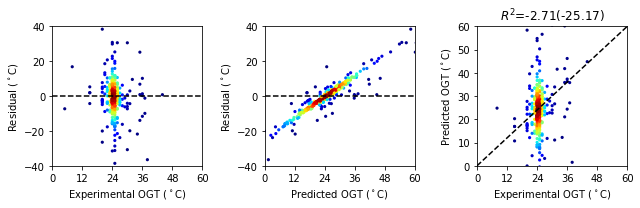

dimer_updated_with_madin_bowman_kingdom_eukaryota.csv_xboxFalse_yboxFalse_BayesRige.csv
(337,) (337,)
(337,) (337,)


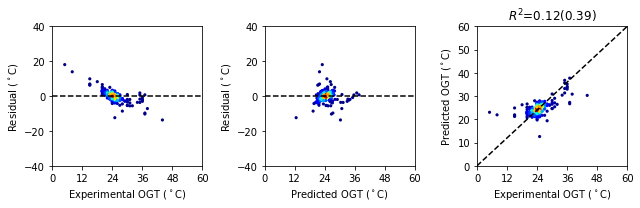

dimer_updated_with_madin_bowman_kingdom_eukaryota.csv_xboxFalse_yboxFalse_SVR model.csv
(337,) (337,)
(337,) (337,)


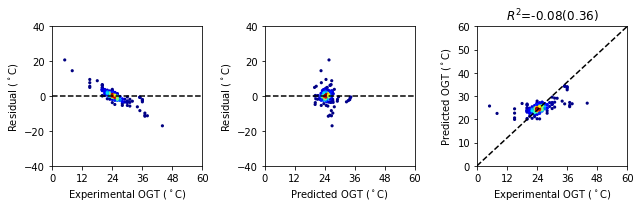

dimer_updated_with_madin_bowman_kingdom_eukaryota.csv_xboxFalse_yboxFalse_Tree model.csv
(337,) (337,)
(337,) (337,)


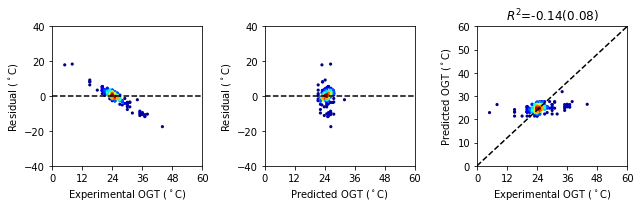

dimer_updated_with_madin_bowman_kingdom_eukaryota.csv_xboxFalse_yboxFalse_Random forest.csv
(337,) (337,)
(337,) (337,)


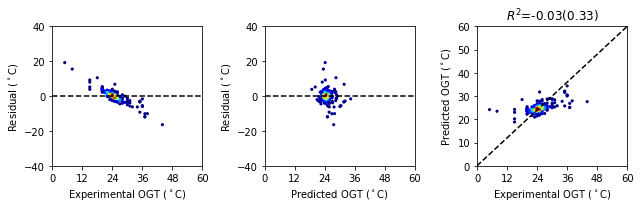

In [10]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and 'ukaryota' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True,lim=[0,60])

dimer_updated_with_madin_bowman_kingdom_bacteria.csv_xboxFalse_yboxFalse_BayesRige.csv
(5203,) (5203,)
(5203,) (5203,)


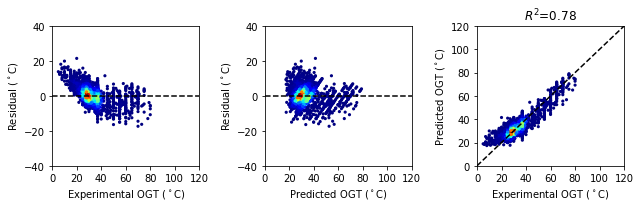

dimer_updated_with_madin_bowman_kingdom_bacteria.csv_xboxFalse_yboxFalse_Tree model.csv
(5203,) (5203,)
(5203,) (5203,)


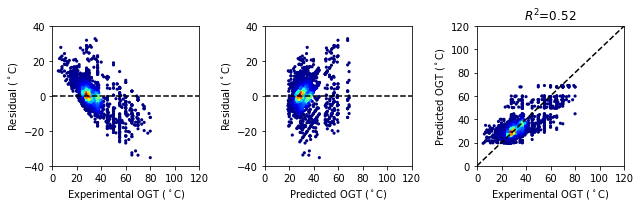

dimer_updated_with_madin_bowman_kingdom_bacteria.csv_xboxFalse_yboxFalse_SVR model.csv
(5203,) (5203,)
(5203,) (5203,)


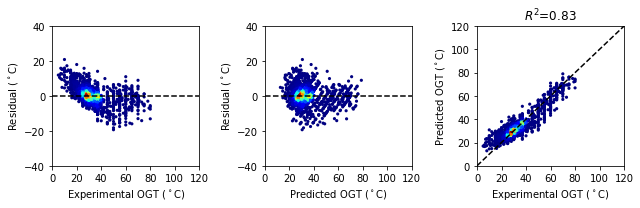

dimer_updated_with_madin_bowman_kingdom_bacteria.csv_xboxFalse_yboxFalse_Linear.csv
(5203,) (5203,)
(5203,) (5203,)


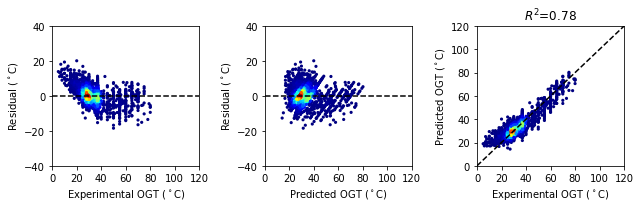

In [62]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and 'bacteria' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile)

dimer_updated_with_madin_bowman_kingdom_binary.csv_xboxFalse_yboxFalse_BayesRige.csv
(5775,) (5775,)
(5775,) (5775,)


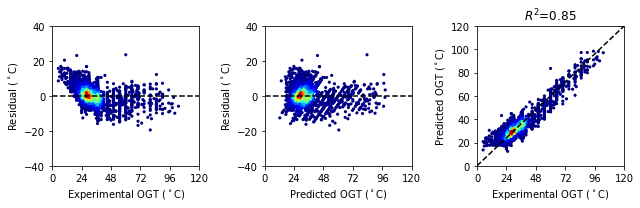

dimer_updated_with_madin_bowman_kingdom_binary.csv_xboxFalse_yboxFalse_Tree model.csv
(5775,) (5775,)
(5775,) (5775,)


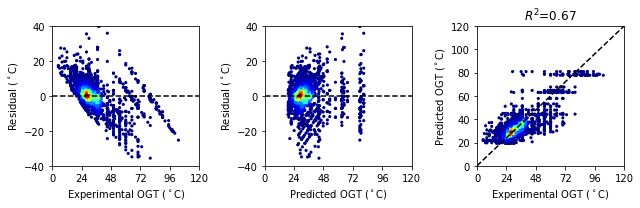

dimer_updated_with_madin_bowman_kingdom_binary.csv_xboxFalse_yboxFalse_Linear.csv
(5775,) (5775,)
(5775,) (5775,)


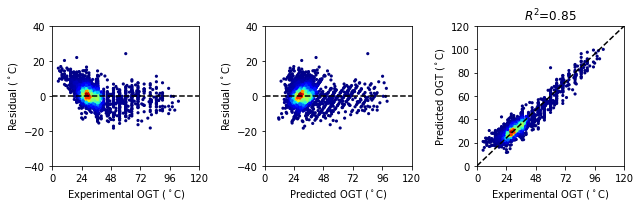

dimer_updated_with_madin_bowman_kingdom_binary.csv_xboxFalse_yboxFalse_Random forest.csv
(5775,) (5775,)
(5775,) (5775,)


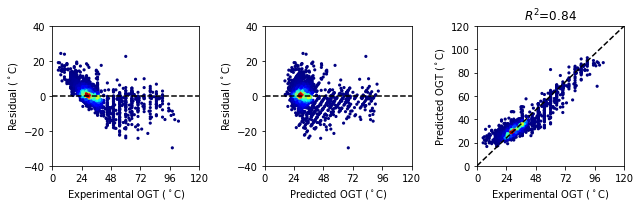

dimer_updated_with_madin_bowman_kingdom_binary.csv_xboxFalse_yboxFalse_SVR model.csv
(5775,) (5775,)
(5775,) (5775,)


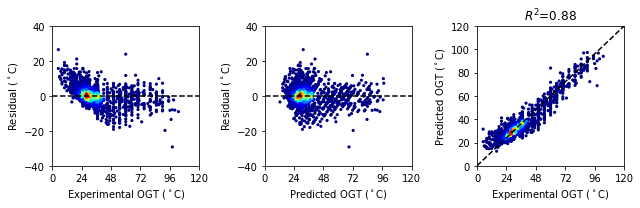

In [15]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and 'binary' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile)

dimer_updated_with_madin_bowman_H40.csv_xboxFalse_yboxFalse_Tree model.csv
(472,) (472,)
(472,) (472,)


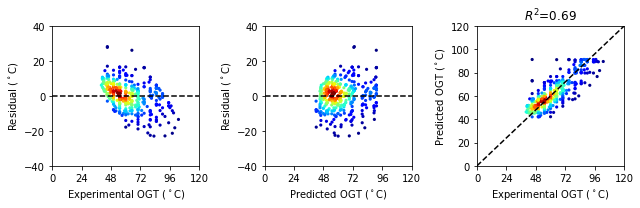

dimer_updated_with_madin_bowman_H40.csv_xboxFalse_yboxFalse_BayesRige.csv
(472,) (472,)
(472,) (472,)


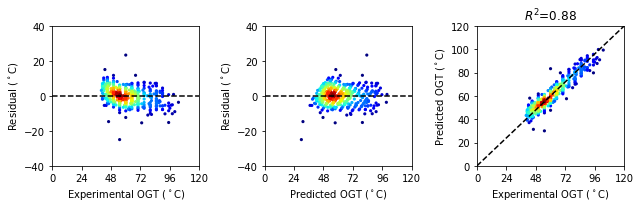

dimer_updated_with_madin_bowman_H40.csv_xboxFalse_yboxFalse_SVR model.csv
(472,) (472,)
(472,) (472,)


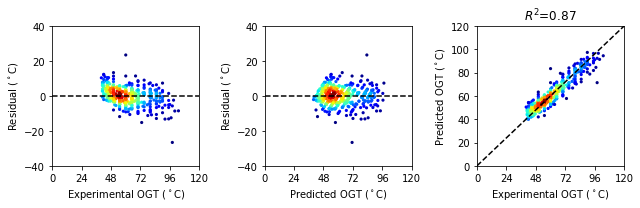

dimer_updated_with_madin_bowman_H40.csv_xboxFalse_yboxFalse_Linear.csv
(472,) (472,)
(472,) (472,)


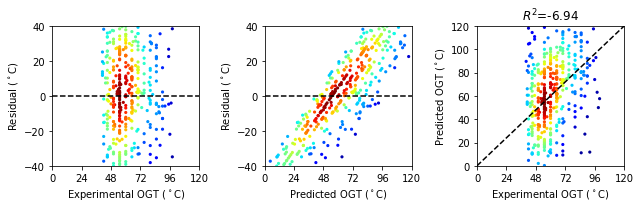

dimer_updated_with_madin_bowman_H40.csv_xboxFalse_yboxFalse_Random forest.csv
(472,) (472,)
(472,) (472,)


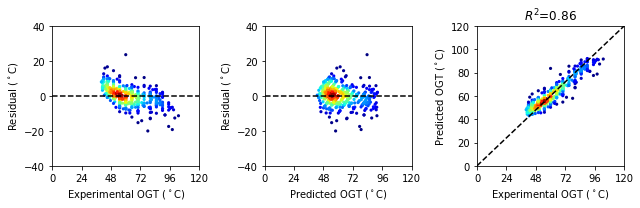

In [11]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and 'H40' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile)

dimer_updated_with_madin_bowman_L40.csv_xboxFalse_yboxFalse_Tree model.csv
(5548,) (5548,)
(5548,) (5548,)


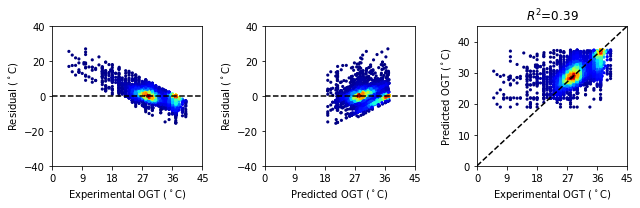

dimer_updated_with_madin_bowman_L40.csv_xboxFalse_yboxFalse_Linear.csv
(5548,) (5548,)
(5548,) (5548,)


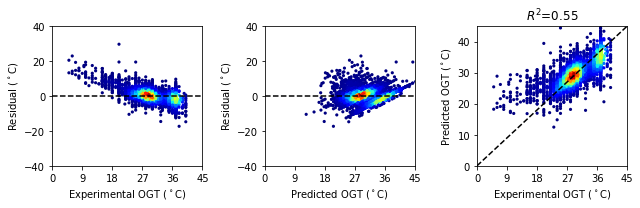

dimer_updated_with_madin_bowman_L40.csv_xboxFalse_yboxFalse_SVR model.csv
(5548,) (5548,)
(5548,) (5548,)


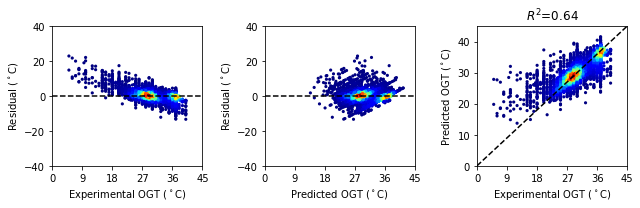

dimer_updated_with_madin_bowman_L40.csv_xboxFalse_yboxFalse_Random forest.csv
(5548,) (5548,)
(5548,) (5548,)


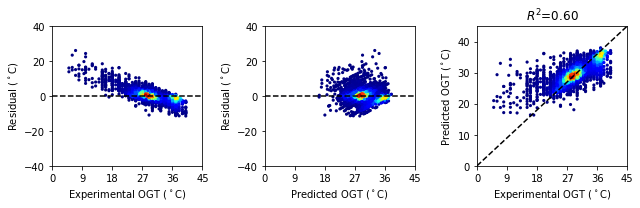

dimer_updated_with_madin_bowman_L40.csv_xboxFalse_yboxFalse_BayesRige.csv
(5548,) (5548,)
(5548,) (5548,)


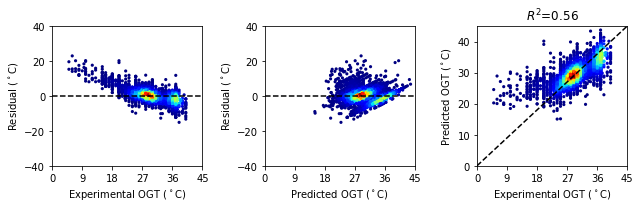

In [14]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and 'L40' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,lim=[0,45])

dimer_updated_with_madin_bowman_0.10_weights.csv_xboxFalse_yboxFalse_Random forest.csv
(6020,) (6020,)
(6020,) (6020,)


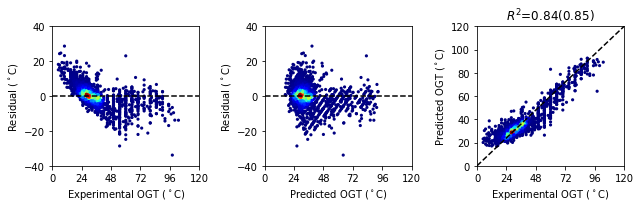

dimer_updated_with_madin_bowman_0.10_weights.csv_xboxFalse_yboxFalse_Tree model.csv
(6020,) (6020,)
(6020,) (6020,)


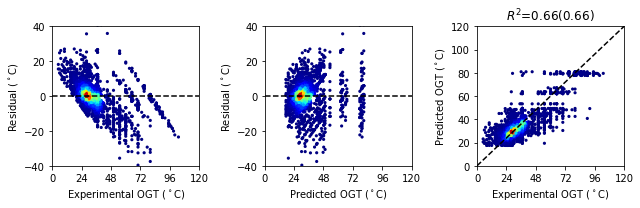

dimer_updated_with_madin_bowman_0.10_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


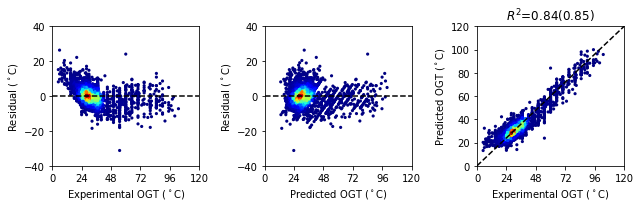

dimer_updated_with_madin_bowman_0.10_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


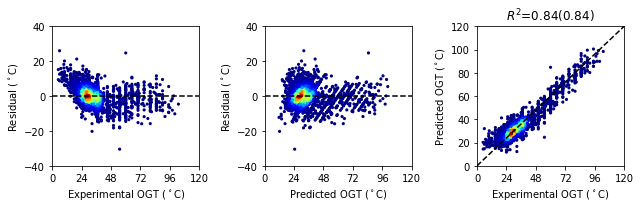

dimer_updated_with_madin_bowman_0.10_weights.csv_xboxFalse_yboxFalse_SVR model.csv
(6020,) (6020,)
(6020,) (6020,)


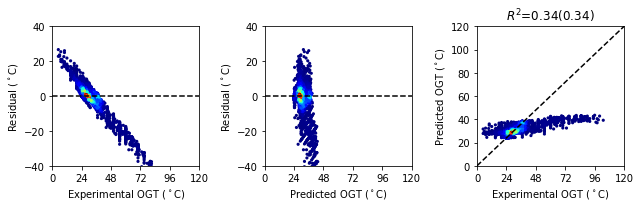

dimer_updated_with_madin_bowman_0.10_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


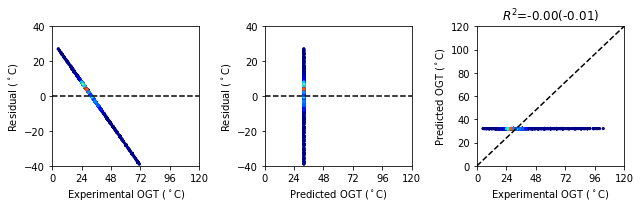

In [44]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and '0.10' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_0.15_weights.csv_xboxFalse_yboxFalse_Random forest.csv
(6020,) (6020,)
(6020,) (6020,)


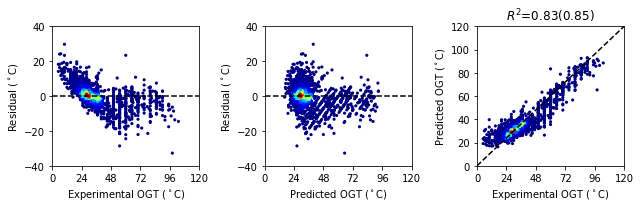

dimer_updated_with_madin_bowman_0.15_weights.csv_xboxFalse_yboxFalse_Tree model.csv
(6020,) (6020,)
(6020,) (6020,)


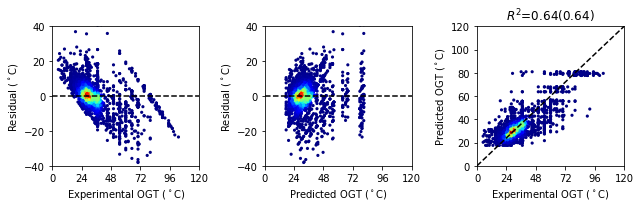

dimer_updated_with_madin_bowman_0.15_weights.csv_xboxFalse_yboxFalse_SVR model.csv
(6020,) (6020,)
(6020,) (6020,)


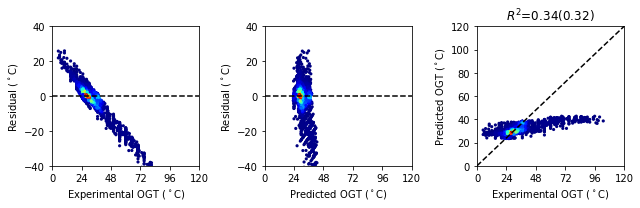

dimer_updated_with_madin_bowman_0.15_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


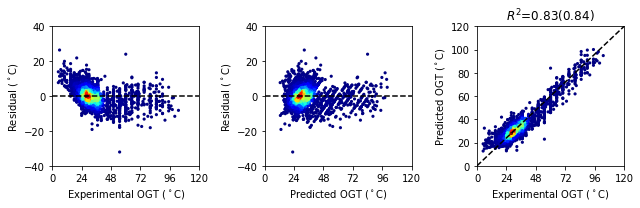

dimer_updated_with_madin_bowman_0.15_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


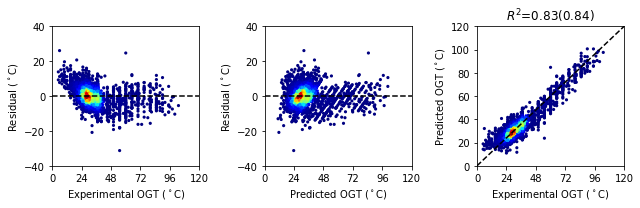

In [45]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and '0.15' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_0.20_weights.csv_xboxFalse_yboxFalse_Random forest.csv
(6020,) (6020,)
(6020,) (6020,)


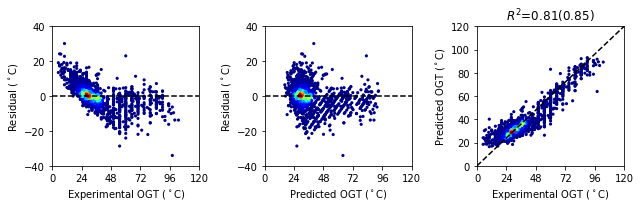

dimer_updated_with_madin_bowman_0.20_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


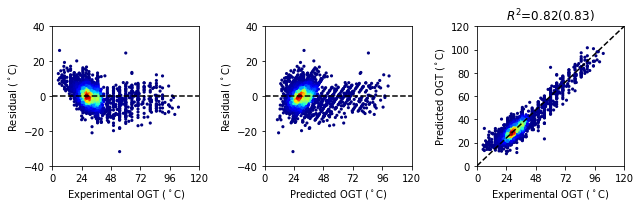

dimer_updated_with_madin_bowman_0.20_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


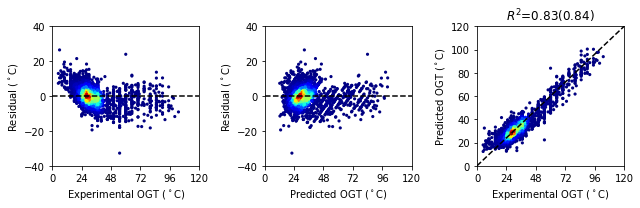

dimer_updated_with_madin_bowman_0.20_weights.csv_xboxFalse_yboxFalse_Tree model.csv
(6020,) (6020,)
(6020,) (6020,)


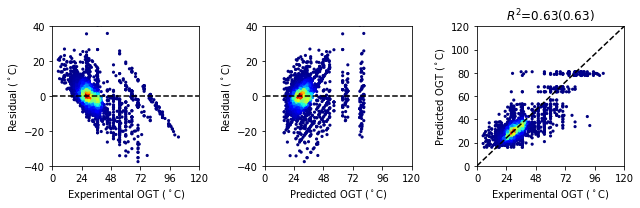

dimer_updated_with_madin_bowman_0.20_weights.csv_xboxFalse_yboxFalse_SVR model.csv
(6020,) (6020,)
(6020,) (6020,)


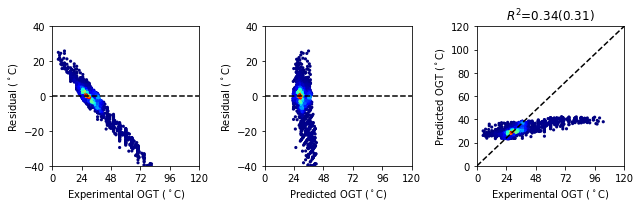

In [46]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and '0.20' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_0.25_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


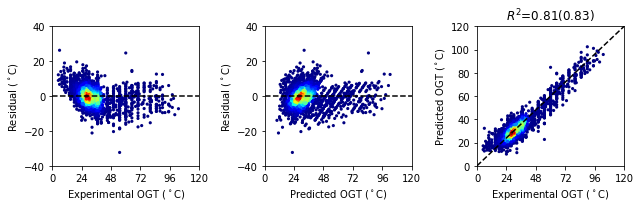

dimer_updated_with_madin_bowman_0.25_weights.csv_xboxFalse_yboxFalse_Tree model.csv
(6020,) (6020,)
(6020,) (6020,)


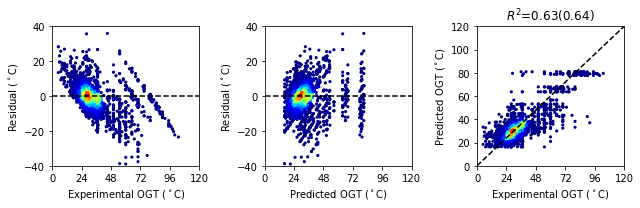

dimer_updated_with_madin_bowman_0.25_weights.csv_xboxFalse_yboxFalse_Random forest.csv
(6020,) (6020,)
(6020,) (6020,)


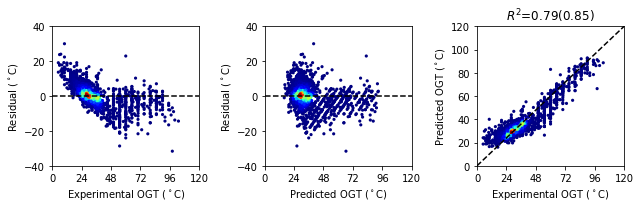

dimer_updated_with_madin_bowman_0.25_weights.csv_xboxFalse_yboxFalse_SVR model.csv
(6020,) (6020,)
(6020,) (6020,)


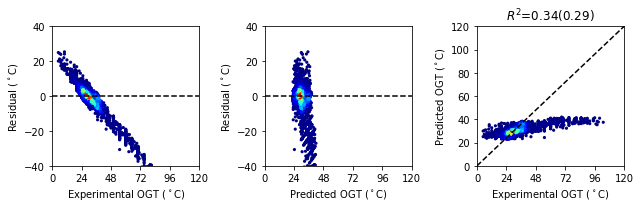

dimer_updated_with_madin_bowman_0.25_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


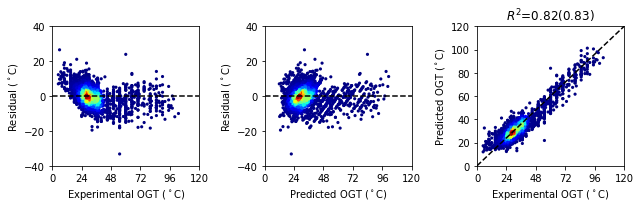

In [47]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and '0.25' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_0.30_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


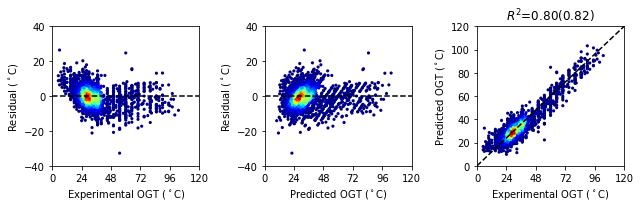

dimer_updated_with_madin_bowman_0.30_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


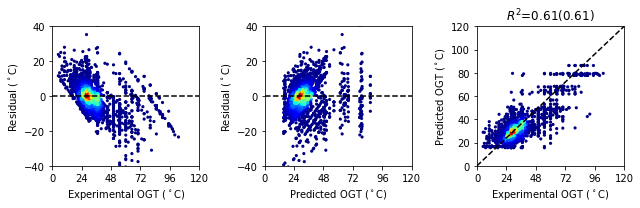

dimer_updated_with_madin_bowman_0.30_weights.csv_xboxFalse_yboxFalse_RandomForest.csv
(6020,) (6020,)
(6020,) (6020,)


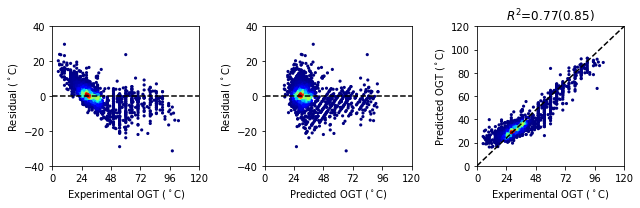

dimer_updated_with_madin_bowman_0.30_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


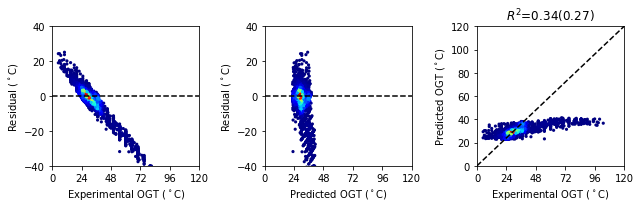

dimer_updated_with_madin_bowman_0.30_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


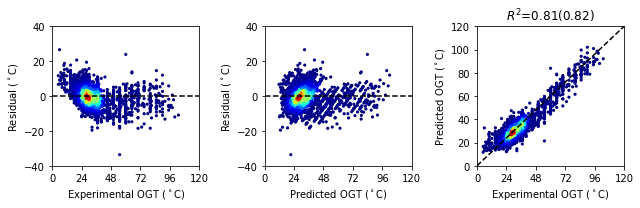

In [48]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and '0.30' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_0.35_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


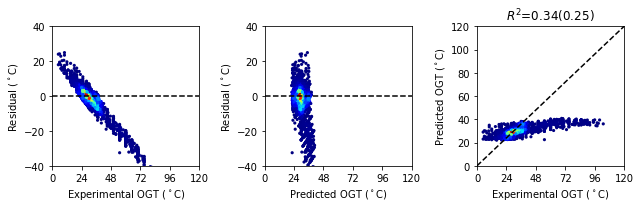

dimer_updated_with_madin_bowman_0.35_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


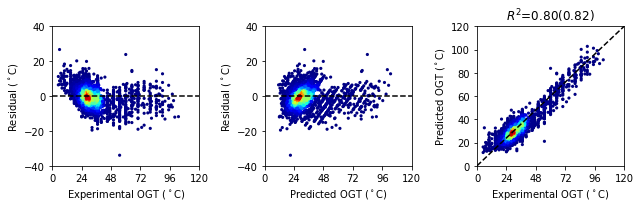

dimer_updated_with_madin_bowman_0.35_weights.csv_xboxFalse_yboxFalse_RandomForest.csv
(6020,) (6020,)
(6020,) (6020,)


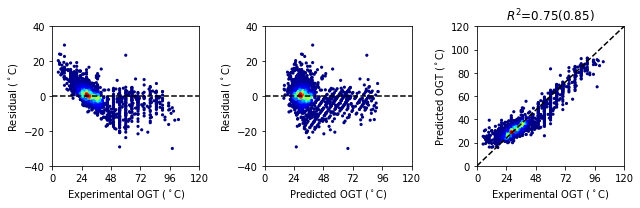

dimer_updated_with_madin_bowman_0.35_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


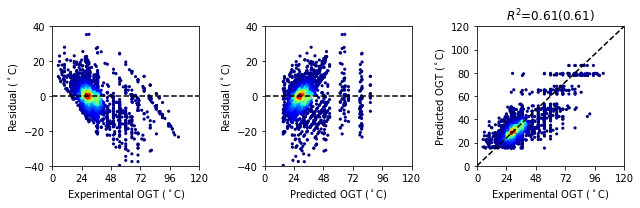

dimer_updated_with_madin_bowman_0.35_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


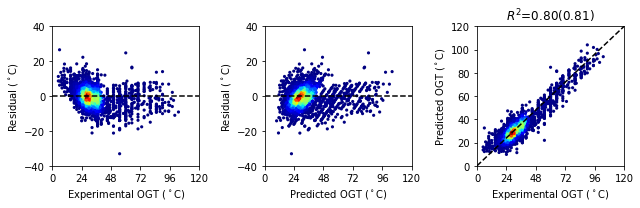

In [49]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and '0.35' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_0.40_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


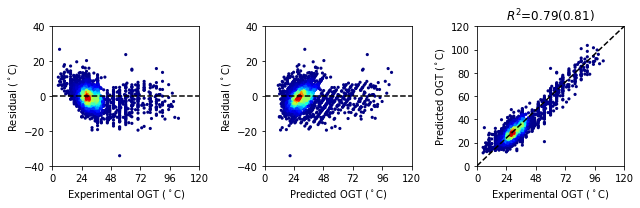

dimer_updated_with_madin_bowman_0.40_weights.csv_xboxFalse_yboxFalse_RandomForest.csv
(6020,) (6020,)
(6020,) (6020,)


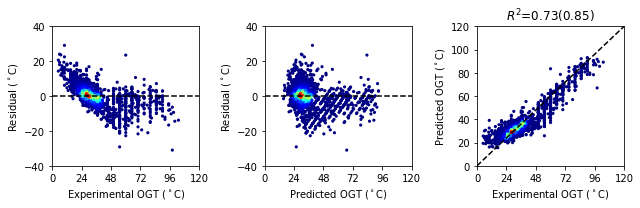

dimer_updated_with_madin_bowman_0.40_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


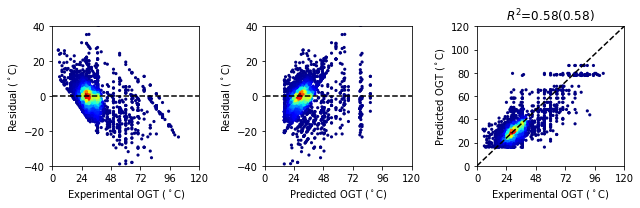

dimer_updated_with_madin_bowman_0.40_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


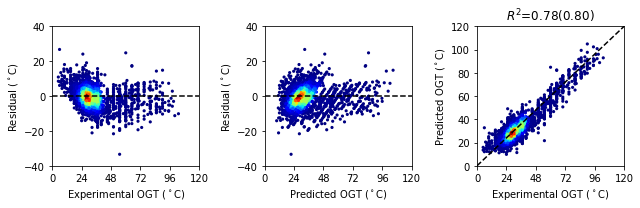

dimer_updated_with_madin_bowman_0.40_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


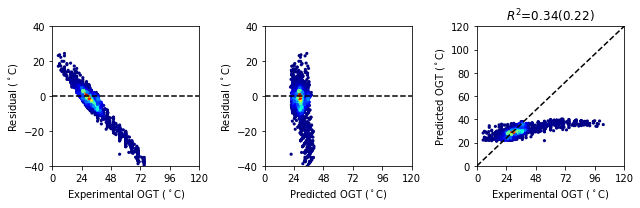

In [50]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and '0.40' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_0.45_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


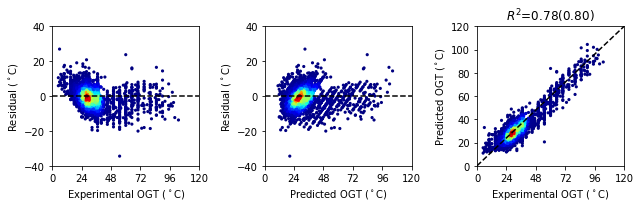

dimer_updated_with_madin_bowman_0.45_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


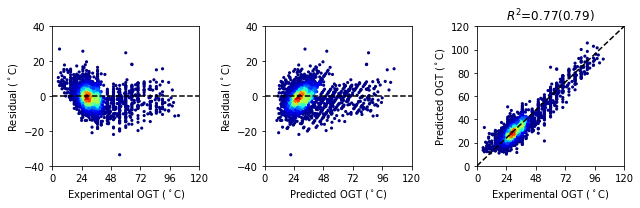

dimer_updated_with_madin_bowman_0.45_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


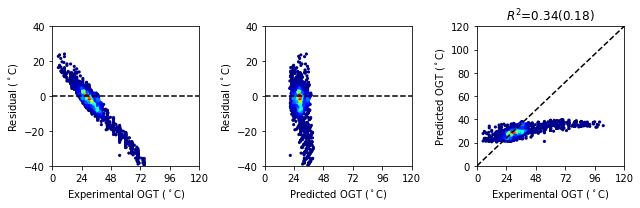

dimer_updated_with_madin_bowman_0.45_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


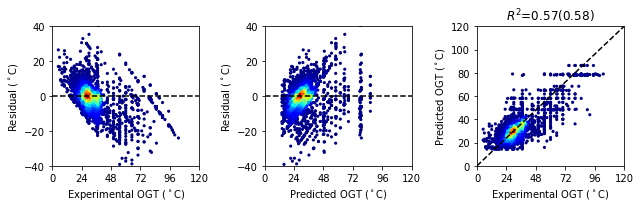

In [51]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and '0.45' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_0.50_weights.csv_xboxFalse_yboxFalse_RandomForest.csv
(6020,) (6020,)
(6020,) (6020,)


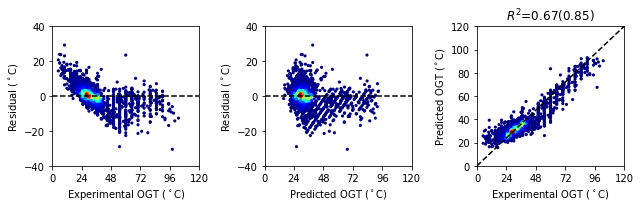

dimer_updated_with_madin_bowman_0.50_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


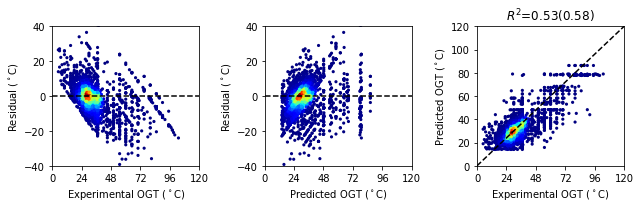

dimer_updated_with_madin_bowman_0.50_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


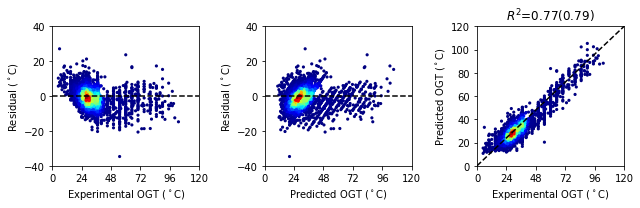

dimer_updated_with_madin_bowman_0.50_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


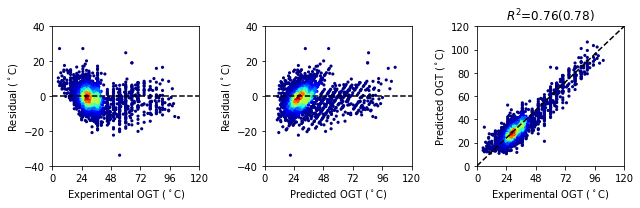

dimer_updated_with_madin_bowman_0.50_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


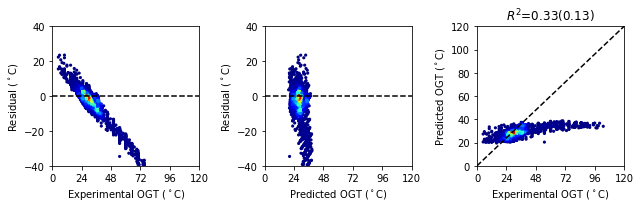

In [52]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and '0.50' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_0.65_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


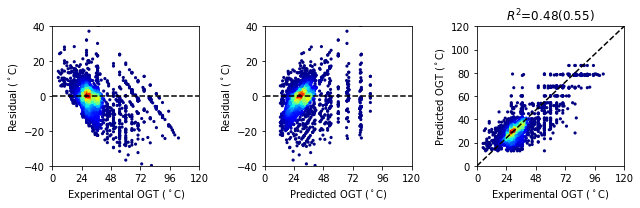

dimer_updated_with_madin_bowman_0.60_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


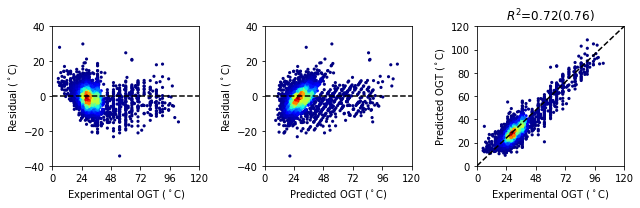

dimer_updated_with_madin_bowman_0.60_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


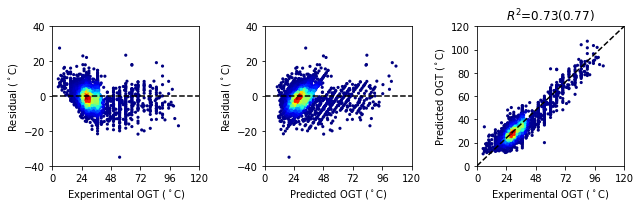

dimer_updated_with_madin_bowman_0.60_weights.csv_xboxFalse_yboxFalse_RandomForest.csv
(6020,) (6020,)
(6020,) (6020,)


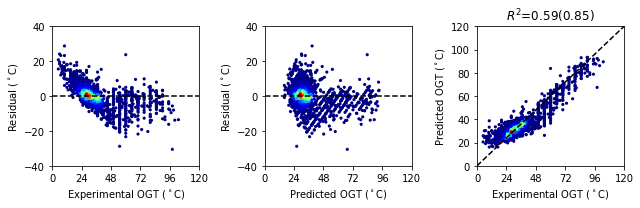

dimer_updated_with_madin_bowman_0.65_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


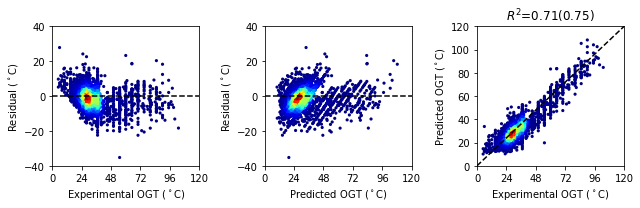

dimer_updated_with_madin_bowman_0.65_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


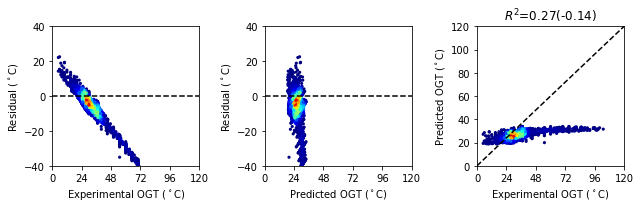

dimer_updated_with_madin_bowman_0.65_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


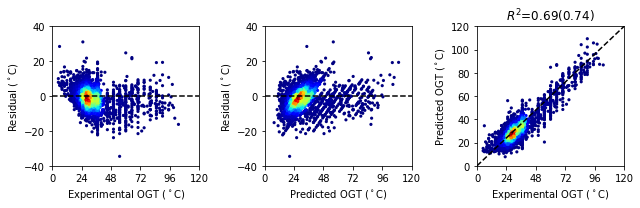

dimer_updated_with_madin_bowman_0.60_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


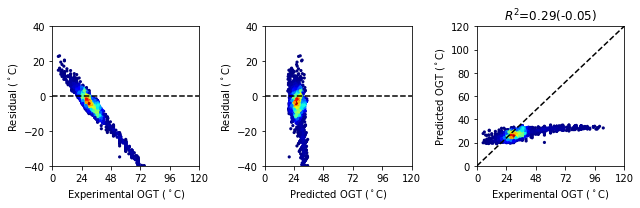

dimer_updated_with_madin_bowman_0.65_weights.csv_xboxFalse_yboxFalse_RandomForest.csv
(6020,) (6020,)
(6020,) (6020,)


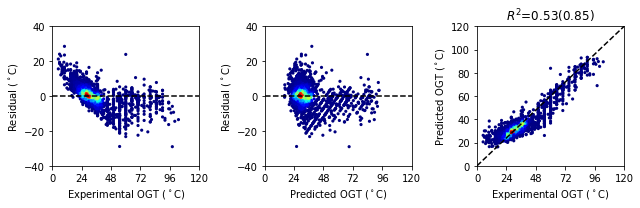

dimer_updated_with_madin_bowman_0.60_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


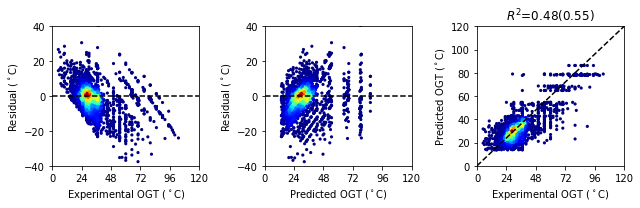

In [53]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and '0.6' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_0.75_weights.csv_xboxFalse_yboxFalse_RandomForest.csv
(6020,) (6020,)
(6020,) (6020,)


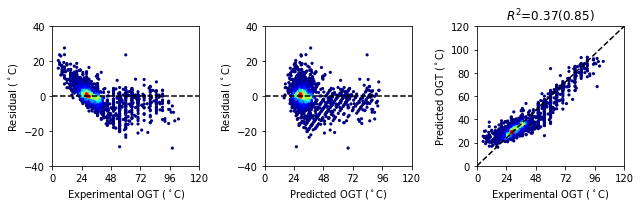

dimer_updated_with_madin_bowman_0.70_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


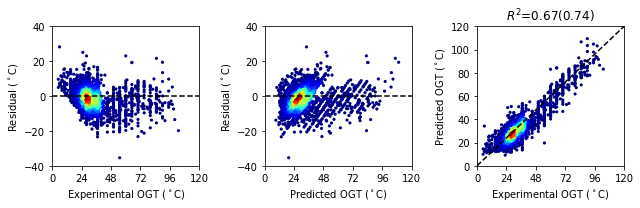

dimer_updated_with_madin_bowman_0.70_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


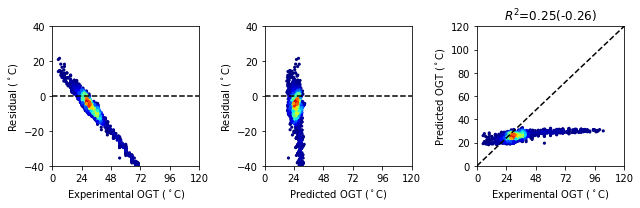

dimer_updated_with_madin_bowman_0.70_weights.csv_xboxFalse_yboxFalse_RandomForest.csv
(6020,) (6020,)
(6020,) (6020,)


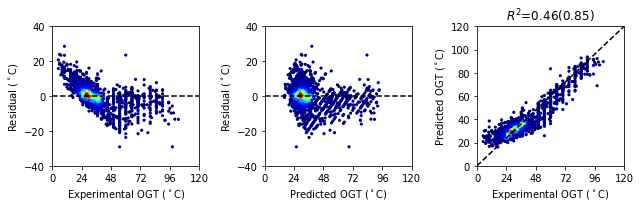

dimer_updated_with_madin_bowman_0.70_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


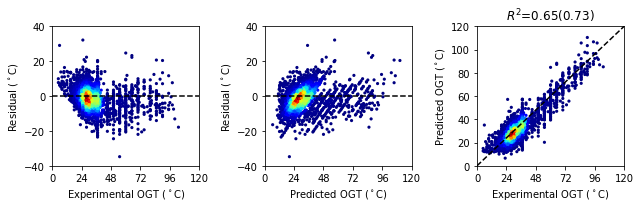

dimer_updated_with_madin_bowman_0.75_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


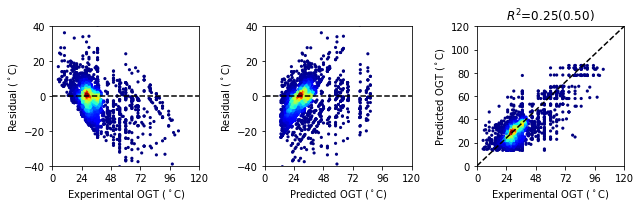

dimer_updated_with_madin_bowman_0.75_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


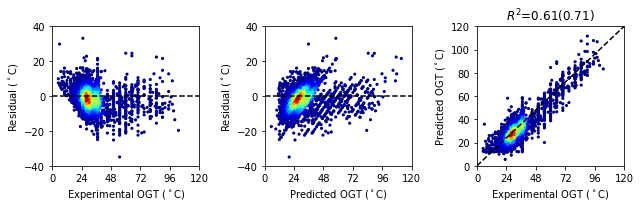

dimer_updated_with_madin_bowman_0.75_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


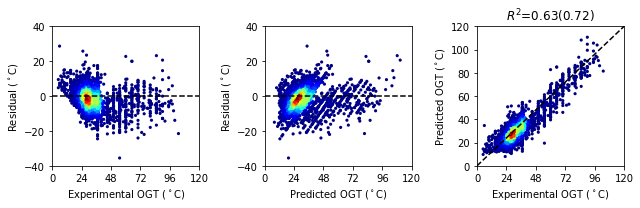

dimer_updated_with_madin_bowman_0.75_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


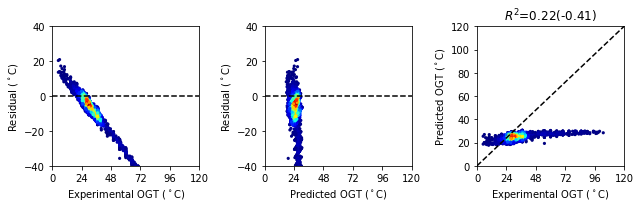

dimer_updated_with_madin_bowman_0.70_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


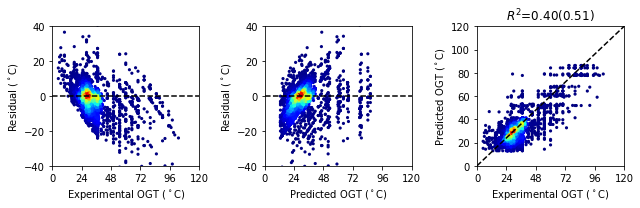

In [54]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and '0.7' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_0.80_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


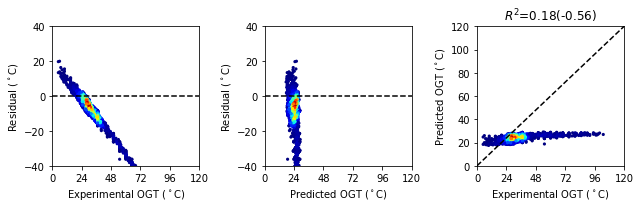

dimer_updated_with_madin_bowman_0.85_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


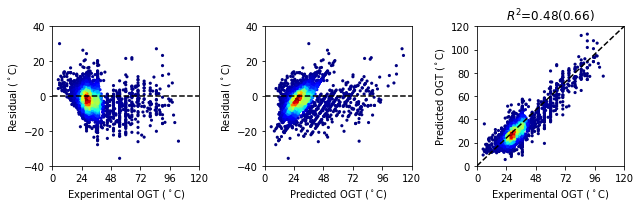

dimer_updated_with_madin_bowman_0.85_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


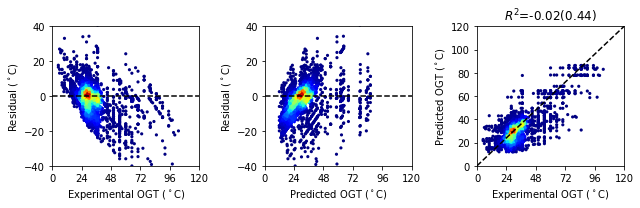

dimer_updated_with_madin_bowman_0.85_weights.csv_xboxFalse_yboxFalse_RandomForest.csv
(6020,) (6020,)
(6020,) (6020,)


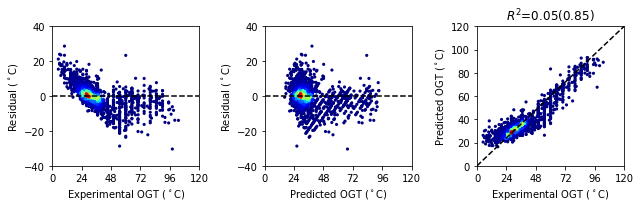

dimer_updated_with_madin_bowman_0.80_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


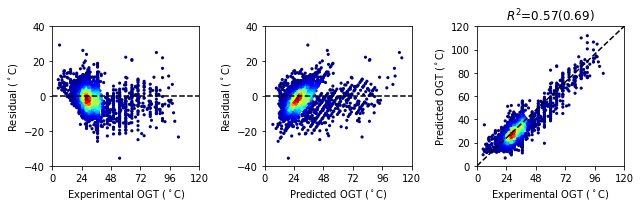

dimer_updated_with_madin_bowman_0.80_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


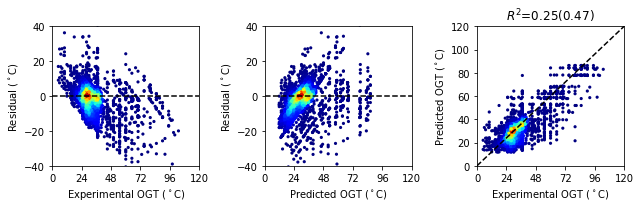

dimer_updated_with_madin_bowman_0.80_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


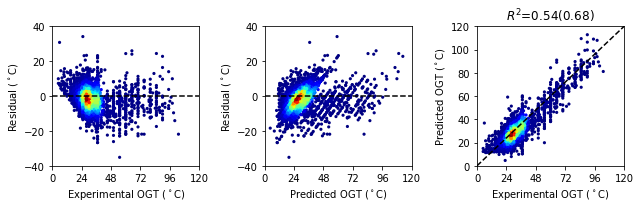

dimer_updated_with_madin_bowman_0.80_weights.csv_xboxFalse_yboxFalse_RandomForest.csv
(6020,) (6020,)
(6020,) (6020,)


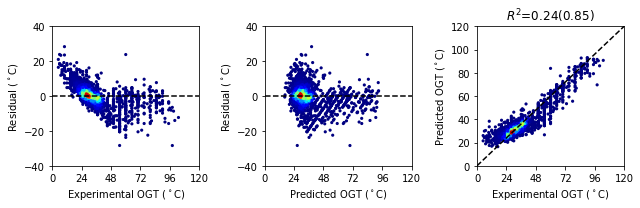

dimer_updated_with_madin_bowman_0.85_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


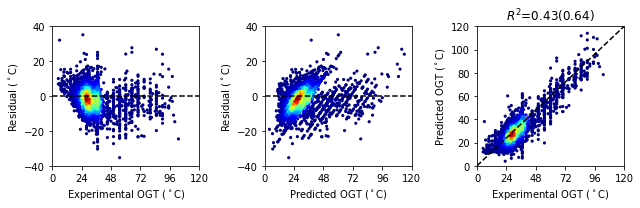

dimer_updated_with_madin_bowman_0.85_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


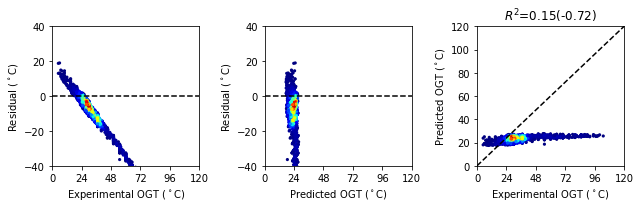

In [55]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and '0.8' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_0.99_weights.csv_xboxFalse_yboxFalse_RandomForest.csv
(6020,) (6020,)
(6020,) (6020,)


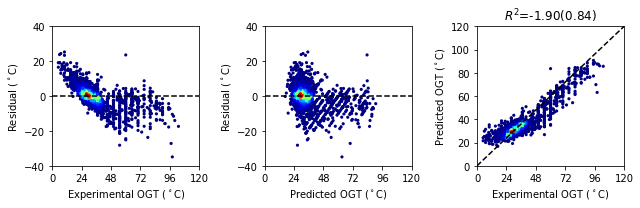

dimer_updated_with_madin_bowman_0.99_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


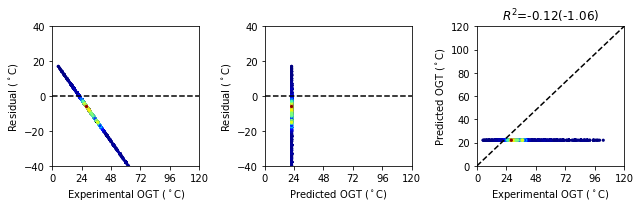

dimer_updated_with_madin_bowman_0.95_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


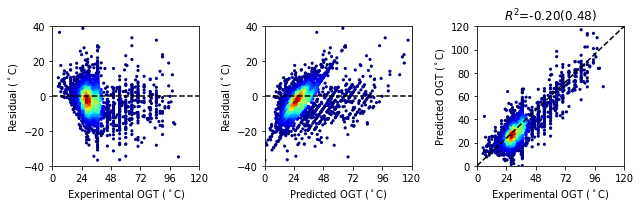

dimer_updated_with_madin_bowman_0.90_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


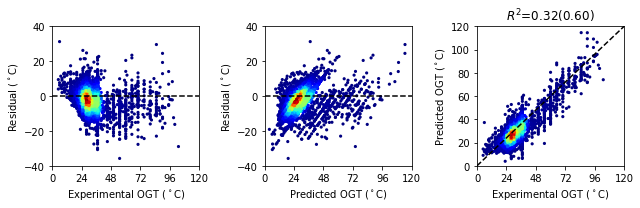

dimer_updated_with_madin_bowman_0.95_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


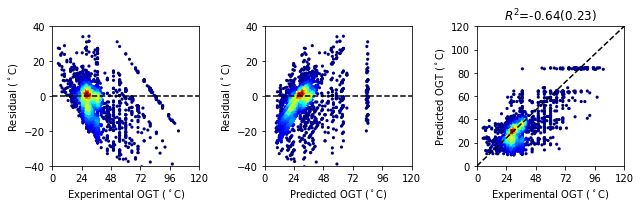

dimer_updated_with_madin_bowman_0.90_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


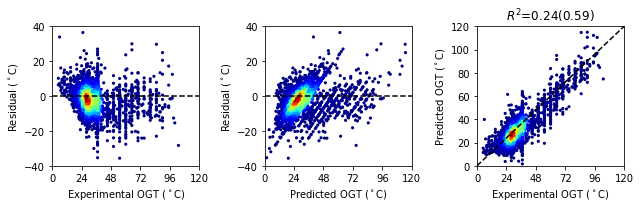

dimer_updated_with_madin_bowman_0.95_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


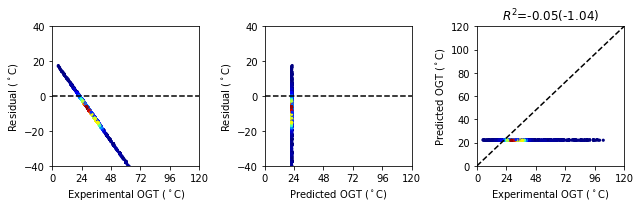

dimer_updated_with_madin_bowman_0.90_weights.csv_xboxFalse_yboxFalse_RandomForest.csv
(6020,) (6020,)
(6020,) (6020,)


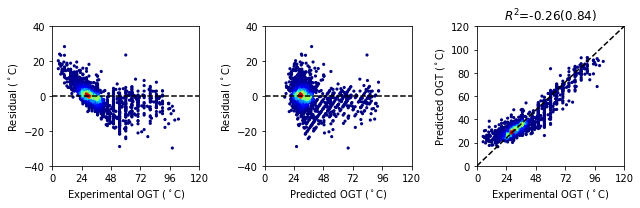

dimer_updated_with_madin_bowman_0.90_weights.csv_xboxFalse_yboxFalse_SVR.csv
(6020,) (6020,)
(6020,) (6020,)


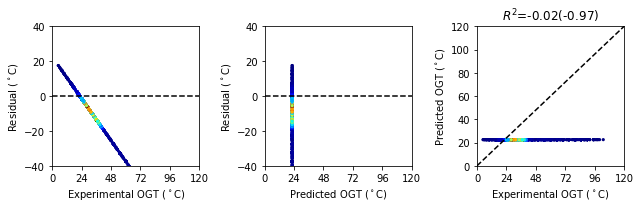

dimer_updated_with_madin_bowman_0.99_weights.csv_xboxFalse_yboxFalse_Linear.csv
(6020,) (6020,)
(6020,) (6020,)


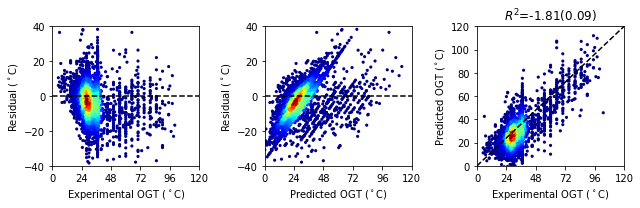

dimer_updated_with_madin_bowman_0.99_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


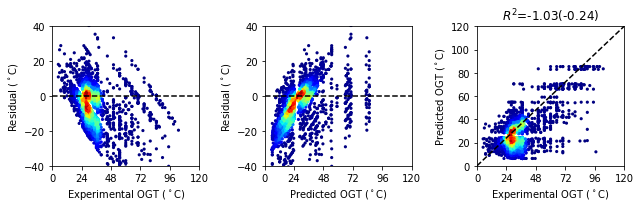

dimer_updated_with_madin_bowman_0.90_weights.csv_xboxFalse_yboxFalse_Tree.csv
(6020,) (6020,)
(6020,) (6020,)


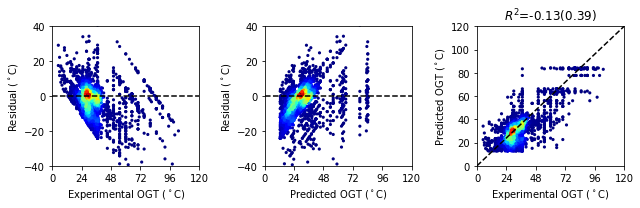

dimer_updated_with_madin_bowman_0.99_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


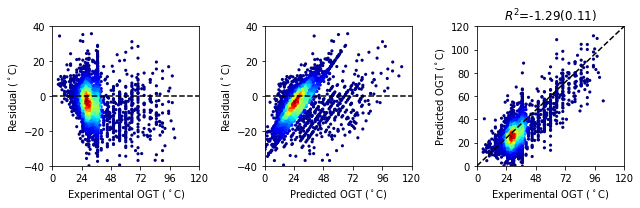

dimer_updated_with_madin_bowman_0.95_weights.csv_xboxFalse_yboxFalse_RandomForest.csv
(6020,) (6020,)
(6020,) (6020,)


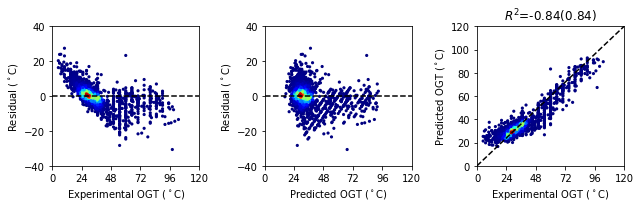

dimer_updated_with_madin_bowman_0.95_weights.csv_xboxFalse_yboxFalse_BayesRige.csv
(6020,) (6020,)
(6020,) (6020,)


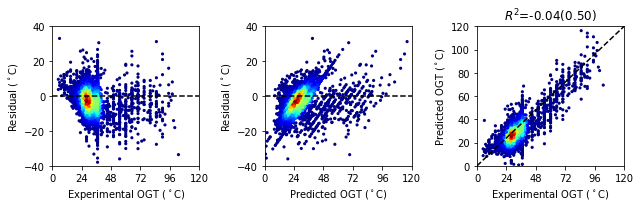

In [56]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and '0.9' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,True)

dimer_updated_with_madin_bowman_H25.csv_xboxFalse_yboxFalse_Tree.csv
(5533,) (5533,)
(5533,) (5533,)


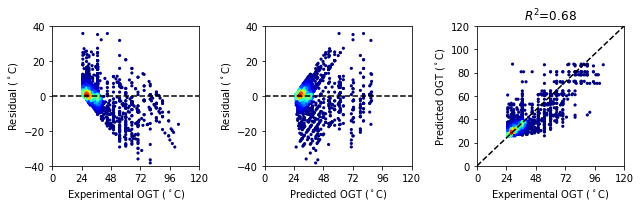

dimer_updated_with_madin_bowman_H25.csv_xboxFalse_yboxFalse_SVR.csv
(5533,) (5533,)
(5533,) (5533,)


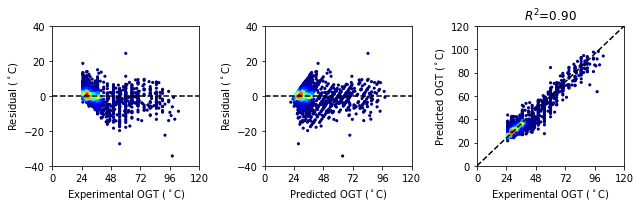

dimer_updated_with_madin_bowman_H25.csv_xboxFalse_yboxFalse_Linear.csv
(5533,) (5533,)
(5533,) (5533,)


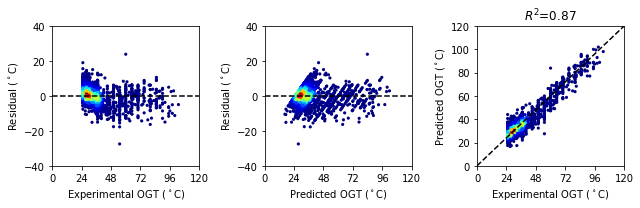

dimer_updated_with_madin_bowman_H25.csv_xboxFalse_yboxFalse_BayesRige.csv
(5533,) (5533,)
(5533,) (5533,)


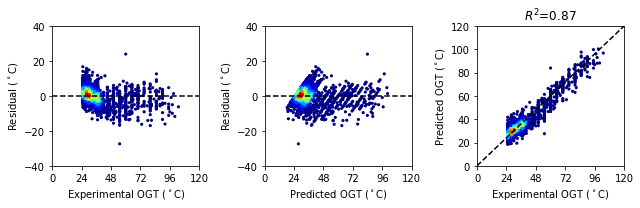

In [57]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and 'H25' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile)

dimer_updated_with_madin_bowman_L25.csv_xboxFalse_yboxFalse_RandomForest.csv
(487,) (487,)
(487,) (487,)


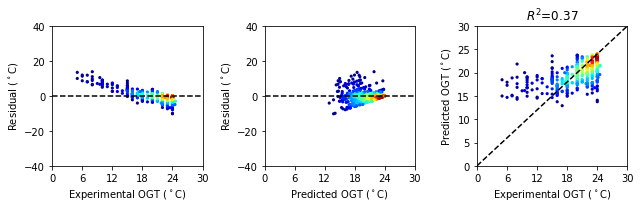

dimer_updated_with_madin_bowman_L25.csv_xboxFalse_yboxFalse_SVR.csv
(487,) (487,)
(487,) (487,)


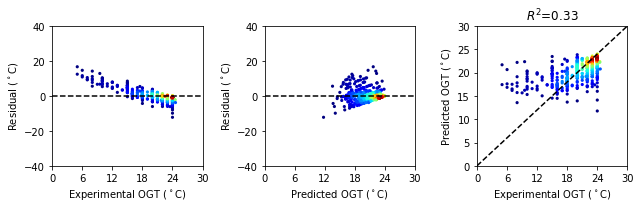

dimer_updated_with_madin_bowman_L25.csv_xboxFalse_yboxFalse_Linear.csv
(487,) (487,)
(487,) (487,)


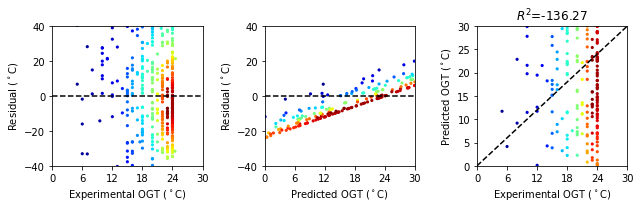

dimer_updated_with_madin_bowman_L25.csv_xboxFalse_yboxFalse_Tree.csv
(487,) (487,)
(487,) (487,)


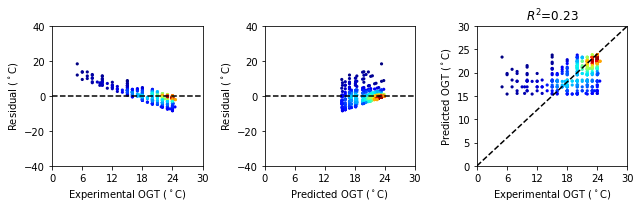

dimer_updated_with_madin_bowman_L25.csv_xboxFalse_yboxFalse_BayesRige.csv
(487,) (487,)
(487,) (487,)


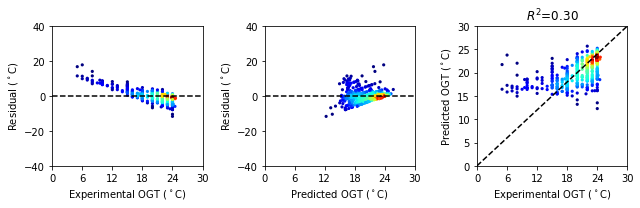

In [58]:
res_dir = '../results/ml_classical_models/'
for name in os.listdir(res_dir):
    if name.endswith('csv') and 'L25' in name:
        print(name)
        infile = os.path.join(res_dir,name)
        plot_errors(infile,lim=[0,30])

#### Fittting

In [40]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [41]:
def normalize(X):
    X_n = np.zeros_like(X)
    k = 0
    for i in range(X.shape[1]):
        x = X[:,i]
        
        
        if np.var(x) != 0:X_n[:,k] = (x-np.mean(x))/np.var(x)**0.5
        k+=1
    return X_n

In [42]:
def svr():
    parameters={
                'C':np.logspace(-5,10,num=16,base=2.0),
                'epsilon':[0,0.01,0.1,0.5,1.0,2.0,4.0]
                }
    
    svr = svm.SVR(kernel='rbf')
    model = GridSearchCV(svr,parameters,n_jobs=-1,cv=3)
    return model

In [43]:
def do_fitting_w(infile):
    model = BayesianRidge()
    df = pd.read_csv(infile,index_col=0)
    print(df.shape)
    X,y,w = df.values[:,:-2],df.values[:,-2], df.values[:,-1]
    
    X = normalize(X)
    model.fit(X,y,sample_weight=w)
    
    p = model.predict(X)
    
    return p,y,w

In [44]:
def do_fitting(infile):
    model =svr()
    df = pd.read_csv(infile,index_col=0)
    print(df.shape)
    X,y = df.values[:,:-1],df.values[:,-1]
    
    X = normalize(X)
    model.fit(X,y)
    
    p = model.predict(X)
    
    return p,y

In [45]:
def plot_errors_fitting(ture,predict,w=None,weighted_r2=False,lim=None):
    x = ture
    y = predict
    
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    dense_plot(x,y-x)
    plt.xlabel('Experimental OGT ($^\circ$C)')
    plt.ylabel('Residual ($^\circ$C)')
    plt.ylim([-40,40])
    
    #lim = get_lim(df['true'],df['pred'])
    if lim is None:lim = [0,120]
    plt.plot(lim,[0,0],'k--')
    
    plt.xlim(lim)
    intv = (lim[1]-lim[0])//5
    plt.xticks(np.arange(lim[0],lim[1]+intv,intv))
    
    plt.subplot(1,3,2)
    dense_plot(y,y-x)
    plt.xlabel('Predicted OGT ($^\circ$C)')
    plt.ylabel('Residual ($^\circ$C)')
    
    plt.ylim([-40,40])
    plt.plot(lim,[0,0],'k--')
    plt.xlim(lim)
    
    intv = (lim[1]-lim[0])//5
    plt.xticks(np.arange(lim[0],lim[1]+intv,intv))
    
    plt.subplot(1,3,3)
    if weighted_r2: r2w = r2_score(x,y,sample_weight=w)
    r2 = r2_score(x,y)

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    plt.scatter(x, y, c=z, s=10, edgecolor='')
    plt.xlabel('Experimental OGT ($^\circ$C)')
    plt.ylabel('Predicted OGT ($^\circ$C)')
    plt.plot(lim,lim,'k--')
    plt.xlim(lim)
    plt.xticks(np.arange(lim[0],lim[1]+intv,intv))
    plt.ylim(lim)
    #if weighted_r2:plt.title('$R^2$={0:.2f}({1:.2f})'.format(r2w,r2))
    #else: plt.title('$R^2$={0:.2f}'.format(r2))
    plt.title('$R^2$={0:.2f}'.format(r2))
    plt.tight_layout()
    plt.show()

In [46]:
def plot_residual_comparison(df1,df2):
    
    def _load_data(df):
        
        # group orgs based on exp ogt, bin size of 5 degress
        org_bins = {}
        for ind in df.index:
            index = int(df.loc[ind,'true']//5)
            org_bins[index] = org_bins.get(index,[]) + [ind]
        
        # calculate residual
        res_bins = {}
        for index,org_bin in org_bins.items():
            res_bins[index] = [df.loc[ind,'pred']-df.loc[ind,'true'] for ind in org_bin]
            
                
        # sorted_nbins
        lst = list(res_bins.items())
        lst.sort()
        
        sorted_bins = [item[1] for item in lst]
        temps = [item[0]*5+2.5 for item in lst]
        return sorted_bins,temps
    
    def _extract_percentiles(bins):
        ps = list()
        for mem in bins:
            ps.append(list(np.percentile(mem,[2.5,50,97.5]))) 
        return np.array(ps)
    
    def _do_fill_plot(temp,ps,label):
        plt.plot(temp,ps[:,1],label=label)
        plt.fill_between(temp,ps[:,0],ps[:,2],alpha=0.5)
        
    
    sorted_bins1,temps1 = _load_data(df1)
    sorted_bins2,temps2 = _load_data(df2)   
        
    ps1 = _extract_percentiles(sorted_bins1)
    ps2 = _extract_percentiles(sorted_bins2)
    
    plt.figure(figsize=(4,3))
    _do_fill_plot(temps1,ps1,'Original')
    _do_fill_plot(temps2,ps2,'Weighted')
    
    lim = [0,120]
    plt.plot(lim,[0,0],'k--')
    plt.xlim(lim)
    plt.ylim([-30,30])
    
    plt.xlabel('Experimental OGT ($^\circ$C)')
    plt.ylabel('Residual ($^\circ$C)')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

In [47]:
p1,y1,w1 = do_fitting_w('../data/dimer_updated_with_madin_bowman_uniform_weights.csv')

(6020, 402)


(6020,) (6020,)
(6020,) (6020,)


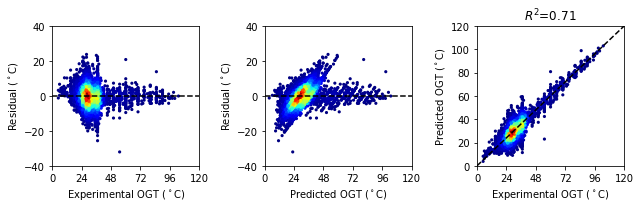

In [48]:
plot_errors_fitting(y1,p1,w1,weighted_r2=True,lim=None)

In [49]:
p,y = do_fitting('../data/dimer_updated_with_madin_bowman.csv')

(6020, 401)


(6020,) (6020,)
(6020,) (6020,)


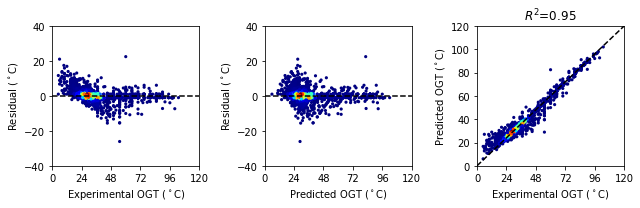

In [50]:
plot_errors_fitting(y,p)

In [51]:
df1 = pd.DataFrame(data={'true':y1,'pred':p1})
df2 = pd.DataFrame(data={'true':y,'pred':p})

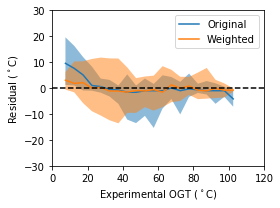

In [52]:
plot_residual_comparison(df2,df1)

In [53]:
import pickle

In [56]:
fhand = open('../results/ml_classical_models/fitting.pkl','wb')
pickle.dump({'SVR_nonWeighted':[y,p],
            'Bayes_Uniform':[y1,p1]},fhand)